In [792]:
import numpy as np 
import pandas as pd 
import plotly.express as px
from numpy.linalg import norm
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score

# Probability Calculation of a person having covid 19

## Loading patients Data

In [793]:
patientsDf = pd.read_csv('patients_data.csv')
patientsDf['date_announced'] = pd.to_datetime(patientsDf['date_announced'], errors = 'coerce')
patientsDf['date_announced'] = pd.to_datetime(patientsDf['date_announced'], format='%d/%m/%Y')
patientsDf['status_change_date'] = pd.to_datetime(patientsDf['status_change_date'], format='%d/%m/%Y')
patientsDf['nationality'] = patientsDf['nationality'].replace('Indian', 'India')

In [794]:
patientsDf.head()

,patient_number,state_patient_number,date_announced,age_bracket,gender,detected_city,detected_district,detected_state,state_code,current_status,notes,suspected_contacted_patient,nationality,type_of_transmission,status_change_date,source_1,source_2,source_3,backup_notes
0,1,KL-TS-P1,2020-01-30,20,F,Thrissur,Thrissur,Kerala,KL,Recovered,Travelled from Wuhan,NaN,India,Imported,2020-02-14,https://twitter.com/vijayanpinarayi/status/122...,https://weather.com/en-IN/india/news/news/2020...,Student from Wuhan,NaN
1,2,KL-AL-P1,2020-02-02,NaN,NaN,Alappuzha,Alappuzha,Kerala,KL,Recovered,Travelled from Wuhan,NaN,India,Imported,2020-02-14,https://www.indiatoday.in/india/story/kerala-r...,https://weather.com/en-IN/india/news/news/2020...,NaN,Student from Wuhan
2,3,KL-KS-P1,2020-03-02,NaN,NaN,Kasaragod,Kasaragod,Kerala,KL,Recovered,Travelled from Wuhan,NaN,India,Imported,2020-02-14,https://www.indiatoday.in/india/story/kerala-n...,https://twitter.com/ANI/status/122422148580539...,https://weather.com/en-IN/india/news/news/2020...,Student from Wuhan
3,4,DL-P1,2020-02-03,45,M,East Delhi (Mayur Vihar),East Delhi,Delhi,DL,Recovered,"Travelled from Austria, Italy",NaN,India,Imported,2020-03-15,https://www.indiatoday.in/india/story/not-a-ja...,https://economictimes.indiatimes.com/news/poli...,NaN,Travel history to Italy and Austria
4,5,TS-P1,2020-02-03,24,M,Hyderabad,Hyderabad,Telangana,TG,Recovered,"Travelled from Dubai to Bangalore on 20th Feb,...",NaN,India,Imported,2020-03-02,https://www.deccanherald.com/national/south/qu...,https://www.indiatoday.in/india/story/coronavi...,https://www.thehindu.com/news/national/coronav...,"Travel history to Dubai, Singapore contact"


## Checking Nan Values

In [795]:
print(patientsDf.shape, '\n')
print(patientsDf.isna().sum())

(12321, 19) 

patient_number                     0
state_patient_number           10221
date_announced                     0
age_bracket                    10814
gender                          9936
detected_city                  10861
detected_district               2171
detected_state                     0
state_code                         1
current_status                     2
notes                           1191
suspected_contacted_patient    10894
nationality                    11024
type_of_transmission            9380
status_change_date               112
source_1                         191
source_2                        9195
source_3                       11998
backup_notes                   11961
dtype: int64


## Deleting features which don't play in calculating probability

In [796]:
patientsDf = patientsDf.drop(columns=['patient_number', 'state_patient_number', 'date_announced', 'state_code', 'current_status','suspected_contacted_patient','suspected_contacted_patient'])

In [797]:
patientsDf = patientsDf.drop(columns=['source_1', 'source_2', 'source_3', 'backup_notes'])
patientsDf = patientsDf.drop(columns=['status_change_date'])

In [798]:
patientsDf = patientsDf.drop(columns=['detected_city'])

In [799]:
patientsDf = patientsDf.dropna()

In [800]:
patientsDf.shape

(695, 7)

In [801]:
patientsDf.head()

,age_bracket,gender,detected_district,detected_state,notes,nationality,type_of_transmission
0,20,F,Thrissur,Kerala,Travelled from Wuhan,India,Imported
3,45,M,East Delhi,Delhi,"Travelled from Austria, Italy",India,Imported
4,24,M,Hyderabad,Telangana,"Travelled from Dubai to Bangalore on 20th Feb,...",India,Imported
5,69,M,Italians*,Rajasthan,Travelled from Italy,Italy,Imported
20,70,F,Italians*,Rajasthan,"Travelled from Italy, Wife of P6",Italy,Imported


## Analysing Notes

In [802]:
patientsDf['notes'] = patientsDf['notes'].replace('Details Awaited', 'Details awaited')
patientsDf['notes'] = patientsDf['notes'].replace('Travelled from Dubai, UAE', 'Travelled from Dubai')
patientsDf['notes'] = patientsDf['notes'].replace('attended religious event Tablighi Jamaat in delhi', 'Attended Delhi Religious Conference')
patientsDf['notes'] = patientsDf['notes'].replace('Travelled from London', 'Travelled from UK')
patientsDf['notes'] = patientsDf['notes'].replace('Travelled from Dubai.', 'Travelled from Dubai')

In [803]:
patientsDf['notes'].value_counts()

Travelled from Dubai                                                                                                                                                                                                38
Travelled from UK                                                                                                                                                                                                   31
Travelled to Delhi                                                                                                                                                                                                  27
Details awaited                                                                                                                                                                                                     18
Travelled from Delhi                                                                                                                        

In [804]:
temppatientsDf = pd.DataFrame(patientsDf.groupby('notes')['notes'].count().sort_values(ascending=False))
temppatientsDf.columns = ['count']
temppatientsDf = temppatientsDf.reset_index()
temppatientsDf = temppatientsDf[temppatientsDf['notes']!='Details awaited']
temppatientsDf.head(10)
fig = px.bar(temppatientsDf.head(10).sort_values('count', ascending=True), x='count', y='notes', orientation='h', text='count', width=600,
       color_discrete_sequence = ['#35495e'], title='Inital Data notes')
fig.update_xaxes(title='')
fig.update_yaxes(title='')

In [805]:
patientsDf['notes'] = patientsDf['notes'].apply(lambda x: x.lower())

## Making categories in notes
Contact means: The person has come in contact with a +ve covid 19 patient(Usually brother, sister, friend, etc. who has visited abroad e )

In [806]:
patientsDf.notes = patientsDf.notes.apply(lambda x: 'wuhan' if 'wuhan' in x else x)
patientsDf.notes = patientsDf.notes.apply(lambda x: 'uk' if 'uk' in x else x)
patientsDf.notes = patientsDf.notes.apply(lambda x: 'uk' if 'scotland' in x else x)
patientsDf.notes = patientsDf.notes.apply(lambda x: 'uk' if 'london' in x else x)
patientsDf.notes = patientsDf.notes.apply(lambda x: 'uk' if 'united kingdom' in x else x)
patientsDf.notes = patientsDf.notes.apply(lambda x: 'usa' if 'usa' in x else x)
patientsDf.notes = patientsDf.notes.apply(lambda x: 'usa' if 'york' in x else x)
patientsDf.notes = patientsDf.notes.apply(lambda x: 'usa' if 'us' in x else x)
patientsDf.notes = patientsDf.notes.apply(lambda x: 'germany' if 'germany' in x else x)
patientsDf.notes = patientsDf.notes.apply(lambda x: 'denmark' if 'denmark' in x else x)
patientsDf.notes = patientsDf.notes.apply(lambda x: 'turkey' if 'turkey' in x else x)
patientsDf.notes = patientsDf.notes.apply(lambda x: 'italy' if 'italy' in x else x)
patientsDf.notes = patientsDf.notes.apply(lambda x: 'finland' if 'finland' in x else x)
patientsDf.notes = patientsDf.notes.apply(lambda x: 'spain' if 'spain' in x else x)
patientsDf.notes = patientsDf.notes.apply(lambda x: 'sri lanka' if 'lanka' in x else x)
patientsDf.notes = patientsDf.notes.apply(lambda x: 'dubai' if 'dubai' in x else x)
patientsDf.notes = patientsDf.notes.apply(lambda x: 'singapore' if 'singapore' in x else x)
patientsDf.notes = patientsDf.notes.apply(lambda x: 'austrialia' if 'australia' in x else x)
patientsDf.notes = patientsDf.notes.apply(lambda x: 'newZealand' if 'zealand' in x else x)
patientsDf.notes = patientsDf.notes.apply(lambda x: 'middleEast' if 'mecca' in x else x)
patientsDf.notes = patientsDf.notes.apply(lambda x: 'middleEast' if 'saudi' in x else x)
patientsDf.notes = patientsDf.notes.apply(lambda x: 'middleEast' if 'edenburg' in x else x)
patientsDf.notes = patientsDf.notes.apply(lambda x: 'middleEast' if 'middle east' in x else x)
patientsDf.notes = patientsDf.notes.apply(lambda x: 'ireland' if 'ireland' in x else x)
patientsDf.notes = patientsDf.notes.apply(lambda x: 'sweden' if 'sweden' in x else x)
patientsDf.notes = patientsDf.notes.apply(lambda x: 'middleEast' if 'abhudhabi' in x else x)
patientsDf.notes = patientsDf.notes.apply(lambda x: 'middleEast' if 'abhu dhabi' in x else x)
patientsDf.notes = patientsDf.notes.apply(lambda x: 'middleEast' if 'abu dhabi' in x else x)
patientsDf.notes = patientsDf.notes.apply(lambda x: 'middleEast' if 'abu dhabi' in x else x)
patientsDf.notes = patientsDf.notes.apply(lambda x: 'middleEast' if 'uae' in x else x)
patientsDf.notes = patientsDf.notes.apply(lambda x: 'middleEast' if 'sharjah' in x else x)
patientsDf.notes = patientsDf.notes.apply(lambda x: 'middleEast' if 'oman' in x else x)
patientsDf.notes = patientsDf.notes.apply(lambda x: 'iran' if 'iran' in x else x)
patientsDf.notes = patientsDf.notes.apply(lambda x: 'hidupur' if 'hidupur' in x else x)
patientsDf.notes = patientsDf.notes.apply(lambda x: 'greece' if 'greece' in x else x)
patientsDf.notes = patientsDf.notes.apply(lambda x: 'malaysia' if 'malaysia' in x else x)
patientsDf.notes = patientsDf.notes.apply(lambda x: 'indonesia' if 'indonesia' in x else x)
patientsDf.notes = patientsDf.notes.apply(lambda x: 'indonesia' if 'indonesian' in x else x)
patientsDf.notes = patientsDf.notes.apply(lambda x: 'indonesia' if 'mexico' in x else x)
patientsDf.notes = patientsDf.notes.apply(lambda x: 'qatar' if 'qatar' in x else x)
patientsDf.notes = patientsDf.notes.apply(lambda x: 'paris' if 'paris' in x else x)
patientsDf.notes = patientsDf.notes.apply(lambda x: 'netherlands' if 'netherlands' in x else x)
patientsDf.notes = patientsDf.notes.apply(lambda x: 'sari' if 'sari' in x else x)
patientsDf.notes = patientsDf.notes.apply(lambda x: 'hadDisease' if 'influenza' in x else x)
patientsDf.notes = patientsDf.notes.apply(lambda x: 'hadDisease' if 'influenza' in x else x)
patientsDf.notes = patientsDf.notes.apply(lambda x: 'france' if 'france' in x else x)
patientsDf.notes = patientsDf.notes.apply(lambda x: 'egypt' if 'egypt' in x else x)
patientsDf.notes = patientsDf.notes.apply(lambda x: 'thailand' if 'thailand' in x else x)
patientsDf.notes = patientsDf.notes.apply(lambda x: 'contact' if 'son' in x else x)
patientsDf.notes = patientsDf.notes.apply(lambda x: 'contact' if 'daughter' in x else x)
patientsDf.notes = patientsDf.notes.apply(lambda x: 'contact' if 'wife' in x else x)
patientsDf.notes = patientsDf.notes.apply(lambda x: 'contact' if 'husband' in x else x)
patientsDf.notes = patientsDf.notes.apply(lambda x: 'contact' if 'uncle' in x else x)
patientsDf.notes = patientsDf.notes.apply(lambda x: 'contact' if 'driver' in x else x)
patientsDf.notes = patientsDf.notes.apply(lambda x: 'contact' if 'doctor' in x else x)
patientsDf.notes = patientsDf.notes.apply(lambda x: 'contact' if 'aunt' in x else x)
patientsDf.notes = patientsDf.notes.apply(lambda x: 'contact' if 'brother' in x else x)
patientsDf.notes = patientsDf.notes.apply(lambda x: 'contact' if 'father' in x else x)
patientsDf.notes = patientsDf.notes.apply(lambda x: 'contact' if 'relative' in x else x)
patientsDf.notes = patientsDf.notes.apply(lambda x: 'contact' if 'mother' in x else x)
patientsDf.notes = patientsDf.notes.apply(lambda x: 'contact' if 'neighbour' in x else x)
patientsDf.notes = patientsDf.notes.apply(lambda x: 'contact' if 'grandmother' in x else x)
patientsDf.notes = patientsDf.notes.apply(lambda x: 'contact' if 'family' in x else x)
patientsDf.notes = patientsDf.notes.apply(lambda x: 'contact' if 'roommate' in x else x)
patientsDf.notes = patientsDf.notes.apply(lambda x: 'contact' if 'parents' in x else x)
patientsDf.notes = patientsDf.notes.apply(lambda x: 'contact' if 'worker' in x else x)
patientsDf.notes = patientsDf.notes.apply(lambda x: 'contact' if 'resident' in x else x)
patientsDf.notes = patientsDf.notes.apply(lambda x: 'contact' if 'related' in x else x)
patientsDf.notes = patientsDf.notes.apply(lambda x: 'contact' if 'sister' in x else x)
patientsDf.notes = patientsDf.notes.apply(lambda x: 'contact' if 'pharma' in x else x)
patientsDf.notes = patientsDf.notes.apply(lambda x: 'contact' if 'police' in x else x)
patientsDf.notes = patientsDf.notes.apply(lambda x: 'contact' if 'p681' in x else x)
patientsDf.notes = patientsDf.notes.apply(lambda x: 'contact' if 'contact' in x else x)
patientsDf.notes = patientsDf.notes.apply(lambda x: 'localTransmission' if 'local' in x else x)
patientsDf.notes = patientsDf.notes.apply(lambda x: 'localTransmission' if 'locally' in x else x)
patientsDf.notes = patientsDf.notes.apply(lambda x: 'local' if 'no international' in x else x)
patientsDf.notes = patientsDf.notes.apply(lambda x: 'bangalore' if 'bangalore' in x else x)
patientsDf.notes = patientsDf.notes.apply(lambda x: 'kerala' if 'trivendrum' in x else x)
patientsDf.notes = patientsDf.notes.apply(lambda x: 'bangalore' if 'bengaluru' in x else x)
patientsDf.notes = patientsDf.notes.apply(lambda x: 'bhopal' if 'bhopal' in x else x)
patientsDf.notes = patientsDf.notes.apply(lambda x: 'mumbai' if 'mumbai' in x else x)
patientsDf.notes = patientsDf.notes.apply(lambda x: 'punjab' if 'punjab' in x else x)
patientsDf.notes = patientsDf.notes.apply(lambda x: 'phuket' if 'phuket' in x else x)
patientsDf.notes = patientsDf.notes.apply(lambda x: 'delhi' if 'delhi' in x else x)
patientsDf.notes = patientsDf.notes.apply(lambda x: 'history of Travel' if 'history' in x else x)

In [807]:
patientsDf = patientsDf.rename(columns={"notes" :"Travelled from/to or contact"})

In [808]:
patientsDf.head()

,age_bracket,gender,detected_district,detected_state,Travelled from/to or contact,nationality,type_of_transmission
0,20,F,Thrissur,Kerala,wuhan,India,Imported
3,45,M,East Delhi,Delhi,usa,India,Imported
4,24,M,Hyderabad,Telangana,usa,India,Imported
5,69,M,Italians*,Rajasthan,italy,Italy,Imported
20,70,F,Italians*,Rajasthan,italy,Italy,Imported


In [809]:
temp_patientsDf = pd.DataFrame(patientsDf.groupby('Travelled from/to or contact')['Travelled from/to or contact'].count().sort_values(ascending=False))
temp_patientsDf.columns = ['count']
temp_patientsDf = temp_patientsDf.reset_index()
temp_patientsDf = temp_patientsDf[temp_patientsDf['Travelled from/to or contact']!='details awaited']
temp_patientsDf.head(10)
fig = px.bar(temp_patientsDf.head(10).sort_values('count', ascending=True), x='count', y='Travelled from/to or contact', orientation='h', text='count', width=600,
       color_discrete_sequence = ['#35495e'], title='Mining cases info')
fig.update_xaxes(title='')
fig.update_yaxes(title='')

### Removing rows which having awaiting details as travelled from or to

In [810]:
patientsDf = patientsDf[~patientsDf['Travelled from/to or contact'].str.contains("details")]

In [811]:
patientsDf.head()

,age_bracket,gender,detected_district,detected_state,Travelled from/to or contact,nationality,type_of_transmission
0,20,F,Thrissur,Kerala,wuhan,India,Imported
3,45,M,East Delhi,Delhi,usa,India,Imported
4,24,M,Hyderabad,Telangana,usa,India,Imported
5,69,M,Italians*,Rajasthan,italy,Italy,Imported
20,70,F,Italians*,Rajasthan,italy,Italy,Imported


## Analyzing age Bracket

In [812]:
px.histogram(patientsDf, x='age_bracket', color_discrete_sequence = ['#35495e'], nbins=50, title='Distribution of ages of confirmed patients')

In [813]:
patientsDf.age_bracket = patientsDf.age_bracket.apply(lambda x: '30' if '28-35' in x else x)
patientsDf['age_bracket'].values

array(['20', '45', '24', '69', '70', '45', '16', '27', '59', '65', '45',
       '24', '54', '53', '65', '61', '25', '63', '46', '3', '48', '40',
       '47', '13', '96', '89', '3', '85', '46', '70', '68', '27', '69',
       '26', '76', '65', '45', '33', '33', '27', '37', '43', '21', '24',
       '59', '32', '45', '33', '3', '44', '51', '31', '29', '20', '67',
       '63', '49', '26', '68', '52', '22', '18', '34', '28', '25', '22',
       '56', '25', '27', '44', '20', '68', '35', '21', '67', '33', '30',
       '3', '38', '23', '22', '49', '35', '24', '24', '21', '70', '47',
       '32', '21', '51', '19', '65', '22', '22', '32', '22', '69', '58',
       '24', '38', '20', '22', '34', '47', '37', '35', '20', '41', '18',
       '69', '27', '26', '52', '21', '52', '27', '63', '32', '59', '45',
       '22', '24', '27', '60', '32', '53', '20', '23', '42', '74', '28',
       '59', '63', '41', '32', '38', '67', '26', '53', '39', '19', '35',
       '33', '69', '75', '65', '35', '34', '45', '40', 

In [814]:
patientsDf['age_bracket'] = patientsDf['age_bracket'].astype(int)

In [815]:
categ_num = 1
for i in range(0,90,5):
    patientsDf['age_bracket'] = np.where(patientsDf['age_bracket'].between(i,i+5), categ_num, patientsDf['age_bracket'])
    categ_num = categ_num + 1

In [816]:
patientsDf.head()

,age_bracket,gender,detected_district,detected_state,Travelled from/to or contact,nationality,type_of_transmission
0,4,F,Thrissur,Kerala,wuhan,India,Imported
3,9,M,East Delhi,Delhi,usa,India,Imported
4,5,M,Hyderabad,Telangana,usa,India,Imported
5,14,M,Italians*,Rajasthan,italy,Italy,Imported
20,14,F,Italians*,Rajasthan,italy,Italy,Imported


## Encoding of categorical data using Label Encoder

In [817]:
encoder = LabelEncoder()

In [818]:
patientsDf['gender'] = patientsDf['gender'].map( {'M':0, 'F':1})

In [819]:
patientsDf['detected_district'] = encoder.fit_transform(patientsDf['detected_district'])
encoder.classes_

array(['Agra', 'Ahmadabad', 'Ahmadnagar', 'Aizawl', 'Ajmer', 'Ambala',
       'Amritsar', 'Aurangabad', 'Bagalkote', 'Baghpat', 'Ballari',
       'Bandipore', 'Barnala', 'Belagavi', 'Bengaluru', 'Bengaluru Rural',
       'Bhadradri Kothagudem', 'Bhavnagar', 'Bhopal', 'Bidar',
       'Chandigarh', 'Chengalpattu', 'Chennai', 'Chikkaballapura',
       'Chittoor', 'Coimbatore', 'Dakshina Kannada', 'Davanagere',
       'Dehradun', 'Dharwad', 'East Delhi', 'East Godavari', 'Ernakulam',
       'Erode', 'Faridabad', 'Gadag', 'Gandhinagar',
       'Gautam Buddha Nagar', 'Gaya', 'Ghaziabad', 'Guntur', 'Gurugram',
       'Gwalior', 'Hoshiarpur', 'Hyderabad', 'Imphal West', 'Italians*',
       'Jabalpur', 'Jaipur', 'Jalandhar', 'Jammu', 'Jaunpur', 'Jhunjhunu',
       'Jodhpur', 'Kachchh', 'Kalaburagi', 'Kancheepuram', 'Kangra',
       'Kannur', 'Kapurthala', 'Karimnagar', 'Kasaragod', 'Kendrapara',
       'Khordha', 'Kodagu', 'Kolkata', 'Kollam', 'Kozhikode', 'Krishna',
       'Leh', 'Lucknow', 'L

In [820]:
patientsDf['detected_state'] = encoder.fit_transform(patientsDf['detected_state'])
encoder.classes_

array(['Andaman and Nicobar Islands', 'Andhra Pradesh', 'Bihar',
       'Chandigarh', 'Chhattisgarh', 'Delhi', 'Goa', 'Gujarat', 'Haryana',
       'Himachal Pradesh', 'Jammu and Kashmir', 'Karnataka', 'Kerala',
       'Ladakh', 'Madhya Pradesh', 'Maharashtra', 'Manipur', 'Mizoram',
       'Odisha', 'Puducherry', 'Punjab', 'Rajasthan', 'Tamil Nadu',
       'Telangana', 'Uttar Pradesh', 'Uttarakhand', 'West Bengal'],
      dtype=object)

In [821]:
patientsDf['nationality'] = encoder.fit_transform(patientsDf['nationality'])
encoder.classes_

array(['India', 'Indonesia', 'Italy', 'Myanmar', 'Thailand', 'Tibet',
       'United Kingdom', 'United States of America'], dtype=object)

In [822]:
patientsDf['type_of_transmission'] = encoder.fit_transform(patientsDf['type_of_transmission'])
encoder.classes_

array(['Imported', 'Imported ', 'Local', 'TBD'], dtype=object)

In [823]:
patientsDf['Travelled from/to or contact'] = encoder.fit_transform(patientsDf['Travelled from/to or contact'])
encoder.classes_

array(['bangalore', 'bhopal', 'contact', 'delhi', 'denmark', 'dubai',
       'egypt', 'finland', 'france', 'germany', 'greece', 'hadDisease',
       'hidupur', 'history of Travel', 'indian army jawan', 'indonesia',
       'iran', 'ireland', 'italy',
       'landed in mangalore airport, had been to kasturba medical college attavar',
       'local', 'localTransmission', 'malaysia', 'middleEast', 'mumbai',
       'native of allahabad', 'netherlands', 'newZealand',
       'nurse in a private hospital of gurugram', 'paris',
       'private hospital nurse', 'punjab', 'qatar', 'sari', 'singapore',
       'spain', 'sri lanka', 'sweden', 'thailand',
       'the detailed investigation is under process',
       'travelled from colombo, arrived on 15.03.2020',
       'travelled from to lisbon in portugal', 'travelled from trinidad',
       'travelled from trivandrum', 'travelled to mohali', 'turkey', 'uk',
       'usa', 'wuhan'], dtype=object)

In [824]:
patientsDf.head()

,age_bracket,gender,detected_district,detected_state,Travelled from/to or contact,nationality,type_of_transmission
0,4,1,122,12,48,0,0
3,9,0,30,5,47,0,0
4,5,0,44,23,47,0,0
5,14,0,46,21,18,2,0
20,14,1,46,21,18,2,0


## K- Means Clustering

In [825]:
patientsDf = patientsDf.astype(float)

In [826]:
patientsDf.head()

,age_bracket,gender,detected_district,detected_state,Travelled from/to or contact,nationality,type_of_transmission
0,4.0,1.0,122.0,12.0,48.0,0.0,0.0
3,9.0,0.0,30.0,5.0,47.0,0.0,0.0
4,5.0,0.0,44.0,23.0,47.0,0.0,0.0
5,14.0,0.0,46.0,21.0,18.0,2.0,0.0
20,14.0,1.0,46.0,21.0,18.0,2.0,0.0


In [827]:
X_std = patientsDf.drop(columns=['nationality', 'type_of_transmission', 'detected_district'])

In [828]:
X_std = X_std.drop(columns=['detected_state'])

In [829]:
X_std = X_std.drop(columns=['age_bracket'])

In [830]:
X_s = StandardScaler().fit_transform(X_std)

,gender,Travelled from/to or contact
0,1.0,48.0
3,0.0,47.0
4,0.0,47.0
5,0.0,18.0
20,1.0,18.0
...,...,...
11587,0.0,33.0
11588,0.0,11.0
11589,1.0,2.0
11590,0.0,2.0


In [781]:
kmeans = KMeans(n_clusters=2) # You want cluster the passenger records into 2: Survived or Not survived


In [782]:
kmeans.fit(X_std)


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [783]:
print(kmeans.cluster_centers_)


[[ 0.30566802  6.89878543]
 [ 0.30769231 42.59340659]]


In [784]:
print(kmeans.labels_)


[1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 1
 1 0 0 1 1 1 1 1 1 0 1 0 1 0 0 0 1 0 0 1 1 0 1 0 1 0 0 0 1 1 1 0 1 0 0 1 1
 0 0 0 0 0 1 1 0 0 1 1 0 0 0 0 1 0 1 0 1 1 0 1 1 1 0 1 1 1 0 1 0 0 0 1 1 1
 1 1 1 1 0 0 0 1 0 0 0 0 0 0 0 0 1 1 1 0 0 1 1 1 0 1 0 0 0 1 0 0 0 1 1 1 0
 0 0 0 0 0 0 0 1 0 1 0 0 1 1 0 0 0 1 1 0 0 0 1 1 1 1 0 1 0 0 0 0 0 1 1 1 1
 0 0 0 0 0 0 0 1 1 0 0 1 0 0 0 0 0 1 1 0 1 1 0 0 0 0 0 0 1 0 0 1 1 0 0 1 0
 0 1 1 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 0 0 0 0 1 0 1 1 1 1 1 0 0 1 0 0 0
 1 0 0 0 0 1 1 0 1 0 0 0 0 1 0 0 1 0 0 0 1 1 0 1 0 0 0 0 1 1 0 1 0 1 0 0 1
 0 0 0 0 0 0 1 1 1 1 0 0 1 0 1 1 1 0 0 1 0 0 0 0 1 1 1 0 0 1 0 0 0 0 0 0 1
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1
 1 1 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 1 0 1 0 0 0 0 

In [785]:
y_kmeans = kmeans.predict(X_std)


In [786]:
plt.scatter(X_std[:, 0], X_std[:, -1])
    
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', marker='x')
    
plt.title('Data points and cluster centroids')
plt.show()

TypeError: '(slice(None, None, None), 0)' is an invalid key

In [787]:
plt.scatter(X_std[:, 0], X_std[:, 1], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

TypeError: '(slice(None, None, None), 0)' is an invalid key

In [763]:
print(silhouette_score(X_std, kmeans.labels_))


0.7857562544992374


/anaconda3/lib/python3.7/site-packages/yellowbrick/utils/kneed.py:140: YellowbrickWarning:

No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.

/anaconda3/lib/python3.7/site-packages/yellowbrick/cluster/elbow.py:343: YellowbrickWarning:

No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning



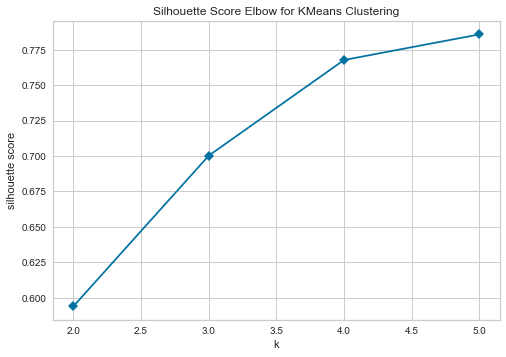

In [764]:
from yellowbrick.cluster import KElbowVisualizer

# Instantiate a scikit-learn K-Means model
model = KMeans(random_state=0)

# Instantiate the KElbowVisualizer with the number of clusters and the metric 
visualizer = KElbowVisualizer(model, k=(2,6), metric='silhouette', timings=False)

# Fit the data and visualize
visualizer.fit(X_std)    
visualizer.poof()   